## 1. 필요 모듈 import

In [1]:
!pip install folium
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import folium
import requests
import json
%matplotlib inline
from pandas.io.json import json_normalize
import platform
from folium import plugins
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~') 

## 2. 데이터 불러오기

In [2]:
_path_2019 = os.path.join('../data', '2019년 서울 아파트 실거래가.csv')
_path_2021 = os.path.join('../data', '2021년 서울 아파트 실거래가.csv')

## 2-1. 데이터 전처리

In [3]:
apart_2019 = pd.read_csv(_path_2019, encoding="cp949")
apart_2021 = pd.read_csv(_path_2021, encoding="cp949")

temp_contract_date = apart_2021['계약년월']
apart_2019['거래금액'] = apart_2019['거래금액'].apply(lambda x : ''.join(x.split(',')))
apart_2021['거래금액(만원)'] = apart_2021['거래금액(만원)'].apply(lambda x : ''.join(x.split(',')))
apart_2019['거래금액'] = apart_2019['거래금액'].astype('int64')
apart_2021['거래금액(만원)']= apart_2021['거래금액(만원)'].astype('int64')
apart_2019['계약년월'] = (apart_2019['거래년도'].astype('str')+'-'+apart_2019['거래월'].astype('str')+'-' + apart_2019['거래일자'].astype('str')).astype('datetime64')
apart_2021['계약년월'] = apart_2021['계약년월'].astype('str').apply(lambda x: str(x[:4]) + '-'+str(x[4:])).astype('datetime64')
apart_2019['법정동'] = apart_2019['법정동'].apply(lambda x: ''.join(x.split()))
apart_2021['동']  = apart_2021.loc[apart_2021['해제사유발생일'].notna(), '시군구'].apply(lambda x : x.split()[-1])
apart_2021['null동']  = apart_2021.loc[apart_2021['해제사유발생일'].isna(), '시군구'].apply(lambda x : x.split()[-1])

# apart_2021.rename(columns={'단지명':'아파트이름','전용면적(㎡)':'전용면적','계약년월':'거래년월','계약일':'거래일','거래금액(만원)':'거래금액'}, inplace=True)
# apart_2021


## 2-2. 데이터 개요 확인

In [4]:
# display(apart_2019.describe(), apart_2019.info())
# display("-------------------------------------------------------------")
# display(apart_2021.describe(), apart_2021.info())
# display(apart_2019.corr(), apart_2021.corr())
# display(apart_2019.head(), apart_2021.head())

## 2-3 데이터 시각화 - 상관관계 분석 히트맵

In [5]:
Q3_2019 = apart_2019['거래금액'].quantile(0.75)
Q1_2019 = apart_2019['거래금액'].quantile(0.25)
IQR2019 = Q3_2019 - Q1_2019
lower_fence2019 = Q1_2019 - (IQR2019 * 1.5)   # 보다 작거나
upper_fence2019 = Q3_2019 + (IQR2019 * 1.5)   # 보다 큰 것
print(IQR2019, lower_fence2019, upper_fence2019)

Q3_2021 = apart_2021['거래금액(만원)'].quantile(0.75)
Q1_2021 = apart_2021['거래금액(만원)'].quantile(0.25)
IQR2021 = Q3_2021 - Q1_2021
lower_fence2021 = Q1_2021 - (IQR2021 * 1.5)   # 보다 작거나
upper_fence2021 = Q3_2021 + (IQR2021 * 1.5)   # 보다 큰 것
print(IQR2021, lower_fence2021, upper_fence2021)

54200.0 -36500.0 180300.0
68200.0 -43500.0 229300.0


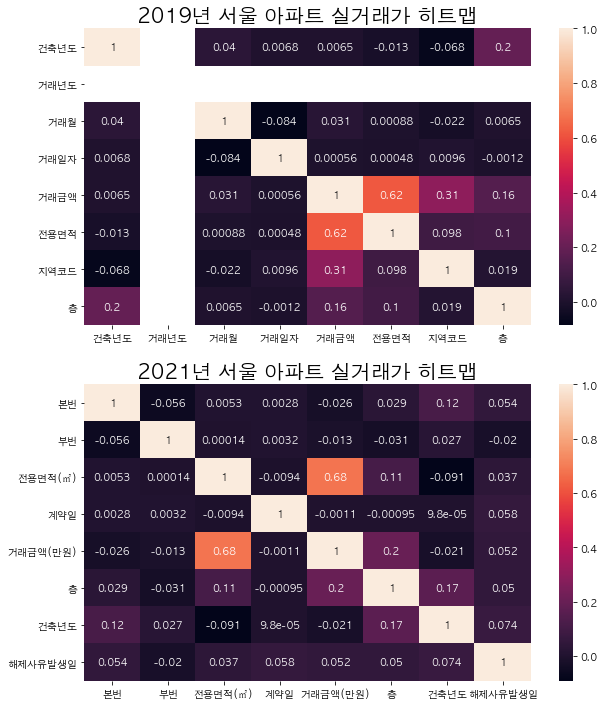

In [6]:
#outlier있는 히트맵
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
sns.heatmap(apart_2019.corr(), annot=True).set_title('2019년 서울 아파트 실거래가 히트맵', fontsize=20)
plt.subplot(2,1,2)
sns.heatmap(apart_2021.corr(), annot=True).set_title('2021년 서울 아파트 실거래가 히트맵', fontsize=20)
plt.show()
apart_2021['계약년월'] = apart_2021['계약년월'].astype('str').apply(lambda x: str(x[:4]) + '-'+str(x[4:])).astype('datetime64')

## 2-4. 데이터 시각화 - 거래금액에 따른 박스 플롯

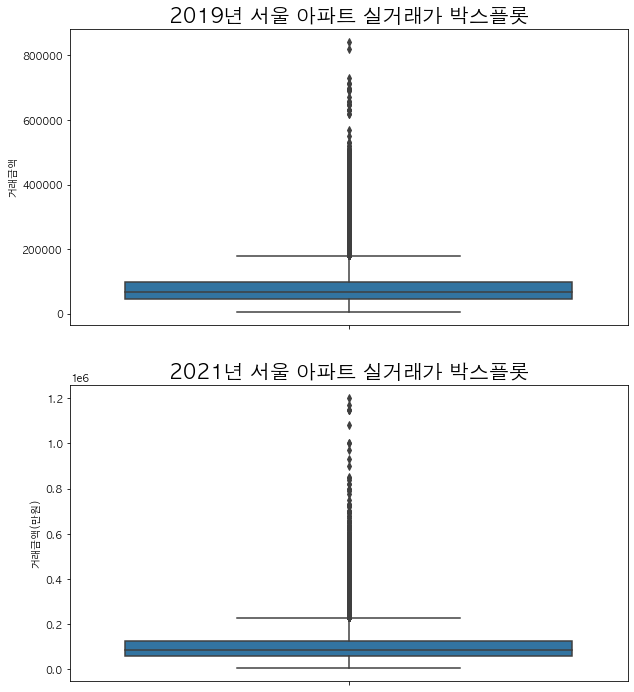

In [7]:
plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
# display(sns.boxplot(x= '거래금액', y='전용면적', data=apart_2019))
sns.boxplot(y= '거래금액', data=apart_2019).set_title('2019년 서울 아파트 실거래가 박스플롯', fontsize=20)
plt.subplot(2,1,2)
# display(sns.boxplot(x= '거래금액(만원)', y='전용면적(㎡)', data=apart_2021))
sns.boxplot(y= '거래금액(만원)', data=apart_2021).set_title('2021년 서울 아파트 실거래가 박스플롯', fontsize=20)
plt.show()

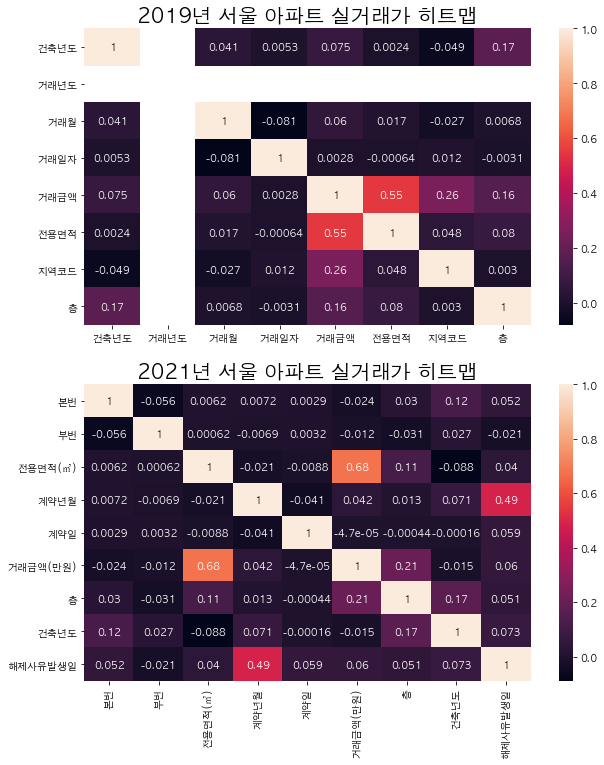

In [8]:
#outlier없는 히트맵
apart_2021['계약년월'] = temp_contract_date
con2019 = apart_2019['거래금액'] <= upper_fence2019
nooutlier_2019 = apart_2019.loc[con2019]

con2021 = apart_2021['거래금액(만원)'] <= upper_fence2021
nooutlier_2021 = apart_2021.loc[con2019]

plt.figure(figsize=(10,12))
plt.subplot(2,1,1)
sns.heatmap(nooutlier_2019.corr(), annot=True).set_title('2019년 서울 아파트 실거래가 히트맵', fontsize=20)
plt.subplot(2,1,2)
sns.heatmap(nooutlier_2021.corr(), annot=True).set_title('2021년 서울 아파트 실거래가 히트맵', fontsize=20)
plt.show()

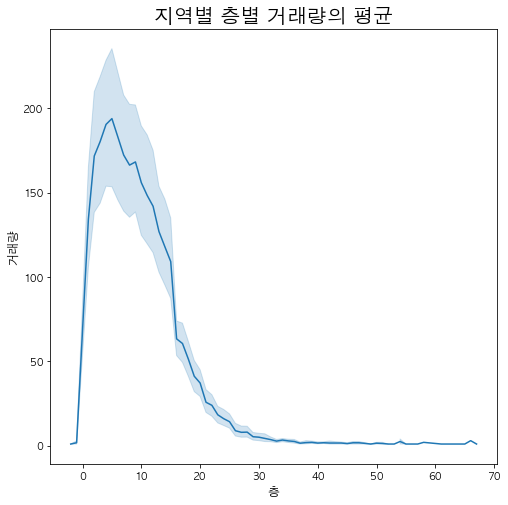

In [9]:
#지역별 층별 거래량의 평균
plt.figure(figsize=(8,8))
floor_count = pd.DataFrame(apart_2019.groupby(['지역코드'])['층'].value_counts()).rename(columns={'층': '거래량'})
sns.lineplot(data=floor_count, x='층', y='거래량')
plt.title('지역별 층별 거래량의 평균', fontsize=20)
plt.xlabel('층', fontsize=12)
plt.ylabel('거래량', fontsize=12)
plt.show()

,층,거래량
0,-2~4,21788
1,5~11,33257
2,12~18,17814
3,19~25,4488
4,26~32,846
5,33~39,218
6,40~46,70
7,47~53,32
8,54~60,13
9,61~67,8


<AxesSubplot:xlabel='층', ylabel='거래량'>

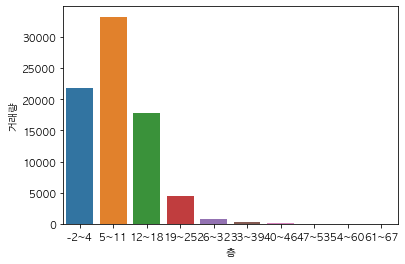

In [10]:
#지역별 7개층당 거래량
floor_list = []
for i in list(set(apart_2019['지역코드'])):
    floor_count_hist = pd.DataFrame(np.array(floor_count.reset_index()).reshape(910,3)).rename(columns={0: '지역코드', 1: '층', 2: '거래량'})
    con = floor_count_hist['지역코드'] == i
    floor_count_hist.loc[con]
    temp_floor = pd.DataFrame(np.array(floor_count.reset_index()).reshape(910,3)).rename(columns={0: '지역코드', 1: '층', 2: '거래량'})
    con = temp_floor['지역코드'] == i
    temp_floor = temp_floor.loc[con]
    for i in range(10):
        
        con2 = (temp_floor['층'] >= i*7-2) & (temp_floor['층'] < i*7+6)
        i = temp_floor.loc[con2]
        
        floor_list.append(i['거래량'].sum())
temp = pd.DataFrame(pd.DataFrame(np.array(floor_list).reshape(25,10)).sum()).rename(columns={0: '거래량'})
for i in range(10):
    temp = temp.rename(index={i: f'{i*7-2}~{i*7+4}'})
temp = temp.reset_index().rename(columns={'index': '층'})
display(temp)
sns.barplot(data=temp, x='층', y='거래량')

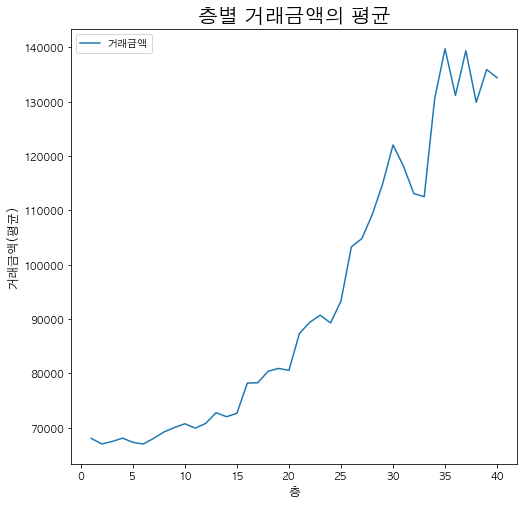

In [11]:
#1층부터 30층까지 층별 거래금액의 평균

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
con_floor = (nooutlier_2019['층'] <= 40) & (1 <= nooutlier_2019['층'])
floor_1_to_30 = nooutlier_2019.loc[con_floor]
floor_1_to_30_mean = pd.DataFrame(floor_1_to_30.groupby(['층'])['거래금액'].mean())
sns.lineplot(data=floor_1_to_30_mean)
plt.title('층별 거래금액의 평균', fontsize=20)
plt.xlabel('층', fontsize=12)
plt.ylabel('거래금액(평균)', fontsize=12)


plt.figure(figsize=(8,8))
plt.subplot(2,1,2)
floor_count = pd.DataFrame(apart_2019.groupby(['지역코드'])['층'].value_counts()).rename(columns={'층': '거래량'})
sns.lineplot(data=floor_count, x='층', y='거래량')
plt.title('지역별 층별 거래량의 평균', fontsize=20)
plt.xlabel('층', fontsize=12)
plt.ylabel('거래량', fontsize=12)
plt.show()

,층,거래량
0,-2~4,21788
1,5~11,33257
2,12~18,17814
3,19~25,4488
4,26~32,846
5,33~39,218
6,40~46,70
7,47~53,32
8,54~60,13
9,61~67,8


<AxesSubplot:xlabel='층', ylabel='거래량'>

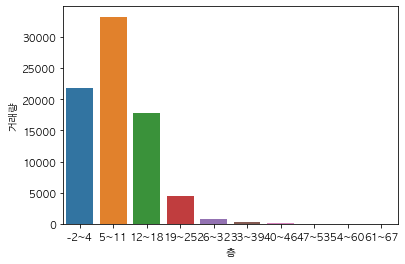

In [12]:
#지역별 7개층당 거래량
floor_list = []
for i in list(set(apart_2019['지역코드'])):
    floor_count_hist = pd.DataFrame(np.array(floor_count.reset_index()).reshape(910,3)).rename(columns={0: '지역코드', 1: '층', 2: '거래량'})
    con = floor_count_hist['지역코드'] == i
    floor_count_hist.loc[con]
    temp_floor = pd.DataFrame(np.array(floor_count.reset_index()).reshape(910,3)).rename(columns={0: '지역코드', 1: '층', 2: '거래량'})
    con = temp_floor['지역코드'] == i
    temp_floor = temp_floor.loc[con]
    for i in range(10):
        
        con2 = (temp_floor['층'] >= i*7-2) & (temp_floor['층'] < i*7+6)
        i = temp_floor.loc[con2]
        
        floor_list.append(i['거래량'].sum())
temp = pd.DataFrame(pd.DataFrame(np.array(floor_list).reshape(25,10)).sum()).rename(columns={0: '거래량'})
for i in range(10):
    temp = temp.rename(index={i: f'{i*7-2}~{i*7+4}'})
temp = temp.reset_index().rename(columns={'index': '층'})
display(temp)
sns.barplot(data=temp, x='층', y='거래량')

In [13]:
from cProfile import label


def split_address(x):
    dong = x.split()[-1]
    return dong
ap1_dong = apart_2021.loc[:, '시군구'].apply(split_address)


apart_2019_new = pd.DataFrame()
apart_2019_new['아파트이름'] = apart_2019['아파트이름'] 
apart_2019_new['동'] = apart_2019['법정동'].str.strip()
apart_2019_new['거래금액']=apart_2019['거래금액'] 
apart_2019_new['계약년월']=apart_2019['계약년월'] 


apart_2021_new = pd.DataFrame()
apart_2021_new['아파트이름'] = apart_2021['단지명']
apart_2021_new['동'] = ap1_dong
apart_2021_new['거래금액'] = apart_2021['거래금액(만원)']
apart_2021_new['계약년월'] = apart_2021['계약년월']


df19 = apart_2019_new.groupby('동')['거래금액'].agg(['mean', 'min', 'max']).reset_index()
df21 = apart_2021_new.groupby('동')['거래금액'].agg(['mean', 'min', 'max']).reset_index()
df = pd.merge(df19, df21,on='동',how='inner')
df['mean_dif'] = df['mean_y']-df['mean_x']
df['min_dif'] = df['min_y']-df['min_x']
df['max_dif'] = df['max_y']-df['max_x']
df.head()

,동,mean_x,min_x,max_x,mean_y,min_y,max_y,mean_dif,min_dif,max_dif
0,가락동,86998.792393,16000,190470,147078.873239,15000,348000,60080.080846,-1000,157530
1,가리봉동,32466.666667,28000,37500,46375.000000,42000,56500,13908.333333,14000,19000
2,가산동,40847.113043,10500,64000,33454.585987,9150,110000,-7392.527056,-1350,46000
3,가양동,57006.531111,20000,130000,84873.451327,36000,181000,27866.920216,16000,51000
4,갈현동,35974.051724,12200,65000,50179.268293,12900,92500,14205.216569,700,27500


### 가은 code
평당 가격과 지역의 관계성 찾기


In [14]:
# 2019년 데이터를 이용하여 동 별 면적당 거래금액 DataFrame 생성
price_of_pyeong_and_area = pd.DataFrame()
price_of_pyeong_and_area['동'] = apart_2019['법정동']
price_of_pyeong_and_area['면적당 거래금액'] = (apart_2019['거래금액'] / apart_2019['전용면적']).round(2)
price_of_pyeong_and_area['면적당 거래금액'].astype('float64')

# 법정동코드, 시도명, 시군구명, 읍면동명 추출
law_dong_excel = pd.read_excel('../data/법정동코드.xlsx')
law_dong_excel = law_dong_excel.loc[law_dong_excel['시도명']=='서울특별시'].iloc[:,0:4]

# 구별 단위 면적당 거래 가격
price_of_pyeong_and_lawarea = pd.merge(price_of_pyeong_and_area, law_dong_excel, how='inner', left_on='동', right_on='읍면동명')
price_of_pyeong_by_goo = price_of_pyeong_and_lawarea.groupby('시군구명')['면적당 거래금액'].agg(['mean', 'min', 'max', 'count']).reset_index()
price_of_pyeong_by_goo['mean'] = (price_of_pyeong_by_goo['mean']).round(2)
# 동별 단위 면적당 거래 가격
price_of_pyeong_by_dong = price_of_pyeong_and_area.groupby(by='동')['면적당 거래금액'].agg(['mean', 'min', 'max','count']).reset_index()

## display 생략 안되도록
# pd.set_option('display.max_rows', None)
# display(price_of_pyeong_and_lowlong.head())

In [15]:
# 서울 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)

# seoul json 수정(면적당 가격)
seoul_fea = seoul_geo['features']
for sl in range(len(seoul_geo['features'])):
    for d in range(len(price_of_pyeong_by_goo)):
        if seoul_fea[sl]['properties']['name'] == price_of_pyeong_by_goo.loc[d]['시군구명']:
            seoul_fea[sl]['properties']['mean_price'] = float(price_of_pyeong_by_goo.loc[d]['mean'])
            seoul_fea[sl]['properties']['min_price'] = float(price_of_pyeong_by_goo.loc[d]['min'])
            seoul_fea[sl]['properties']['max_price'] = float(price_of_pyeong_by_goo.loc[d]['max'])
            seoul_fea[sl]['properties']['count'] = float(price_of_pyeong_by_goo.loc[d]['count'])

# 지도에 데이터 설정
seoul_map = folium.Map(
    location=[37.559819, 126.963895],
    zoom_start=11, 
    tiles='cartodbpositron'
)

seoul_map.choropleth(
    geo_data=seoul_geo,
    data = price_of_pyeong_by_goo,
    columns=['시군구명','mean', 'min', 'max', 'count'],
    fill_color='PuRd',
    key_on='properties.name',
    highlight=True,
    fill_opacity=0.5,
    line_opacity=1,
    legend_name='면적당 평균 거래 가격',
)


style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL = folium.features.GeoJson(
    seoul_geo,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'mean_price','max_price', 'min_price', 'count'],
        aliases=['시군구: ', '평균값: ', '최댓값: ', '최솟값: ', '거래량: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    )
)
seoul_map.add_child(NIL)
seoul_map.keep_in_front(NIL)
folium.LayerControl().add_to(seoul_map)
# 구 별 단위 면적당 평균 거래 가격 지도 시각화
seoul_map.save('seoul_mean_map.html')
seoul_map

/Users/yeongwoo/opt/anaconda3/lib/python3.8/site-packages/folium/folium.py:409: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [16]:
seoul_map2 = folium.Map(
    location=[37.559819, 126.963895],
    zoom_start=11, 
    tiles='cartodbpositron'
)

seoul_map2.choropleth(
    geo_data=seoul_geo,
    data = price_of_pyeong_by_goo,
    columns=['시군구명', 'count'],
    fill_color='PuRd',
    key_on='properties.name',
    highlight=True,
    fill_opacity=0.5,
    line_opacity=1,
    legend_name='면적당 평균 거래 가격',
)


style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.50, 
                                'weight': 0.1}
NIL2 = folium.features.GeoJson(
    seoul_geo,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', 'count'],
        aliases=['시군구: ', '거래량: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
    )
)
seoul_map2.add_child(NIL2)
seoul_map2.keep_in_front(NIL2)
folium.LayerControl().add_to(seoul_map2)
# 구 별 거래량 지도 시각화
seoul_map2.save('seoul_count_map.html')
seoul_map2

In [17]:
position = pd.read_excel('../행정_법정동 중심좌표.xlsx')
position_seoul = position[position['시도']=='서울특별시']

apart_2019_merged = apart_2019.merge(position_seoul, left_on='법정동', right_on='읍면동')
apart_2021_merged = apart_2021.merge(position_seoul, left_on='동', right_on='읍면동') 

position_19_money = apart_2019_merged.groupby(['위도','경도'])[['거래금액']].mean().reset_index()
position_21_money = apart_2021_merged.groupby(['위도','경도'])[['거래금액(만원)']].mean().reset_index()

code_19_money = apart_2019_merged.groupby('코드')[['거래금액']].mean().reset_index()
code_21_money = apart_2021_merged.groupby('코드')[['거래금액(만원)']].mean().reset_index()

geo = json.load(open('../skorea-provinces-geo22.json', encoding='utf-8'))
seoul = folium.Map(location=[37.55, 126.98], zoom_start=12, tiles='cartodbpositron')
seoul.add_child(plugins.HeatMap(zip(position_19_money['위도'], position_19_money['경도'], position_19_money['거래금액']), radius=18))
with open('../skorea-provinces-geo22.json', mode='rt', encoding='utf-8') as f:
    geo = json.loads(f.read())
    f.close()
folium.GeoJson(geo, name = 'seoul').add_to(seoul)
seoul

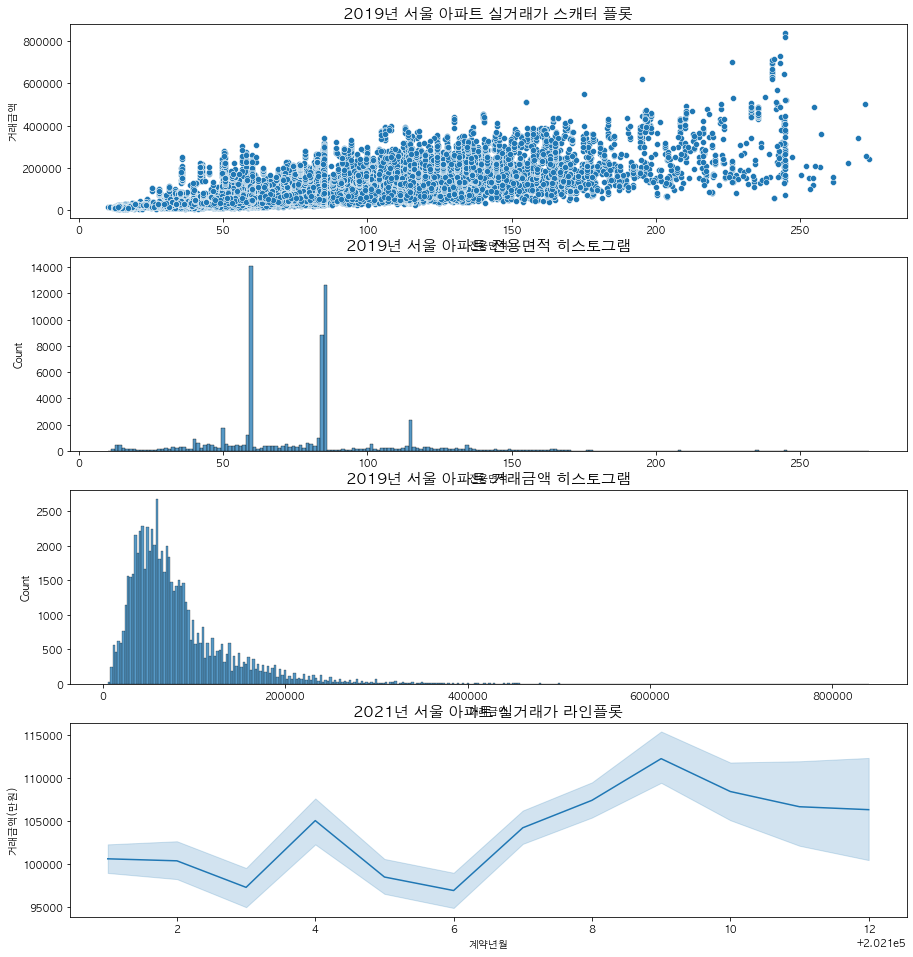

In [18]:
plt.figure(figsize=(15,25))
n = 6
_x = apart_2021.groupby('동')[['거래금액(만원)']].mean().sort_values(by='거래금액(만원)',ascending=False).head().index
_y = apart_2021.groupby('동')[['거래금액(만원)']].mean().sort_values(by='거래금액(만원)',ascending=False).head()['거래금액(만원)']

__x = apart_2019.groupby('법정동')[['거래금액']].mean().sort_values(by='거래금액',ascending=False).head().index
__y = apart_2019.groupby('법정동')[['거래금액']].mean().sort_values(by='거래금액',ascending=False).head()['거래금액']

plt.subplot(n,1,1)
sns.scatterplot(x='전용면적',y= '거래금액', data=apart_2019).set_title('2019년 서울 아파트 실거래가 스캐터 플롯', fontsize=15)
plt.subplot(n,1,2)
sns.histplot(x=apart_2019['전용면적']).set_title('2019년 서울 아파트 전용면적 히스토그램', fontsize=15)
plt.subplot(n,1,3)
sns.histplot(x=apart_2019['거래금액']).set_title('2019년 서울 아파트 거래금액 히스토그램', fontsize=15)
plt.subplot(n,1,4)
sns.lineplot(x='계약년월',y= '거래금액(만원)', data=apart_2021).set_title('2021년 서울 아파트 실거래가 라인플롯', fontsize=15)

plt.show()

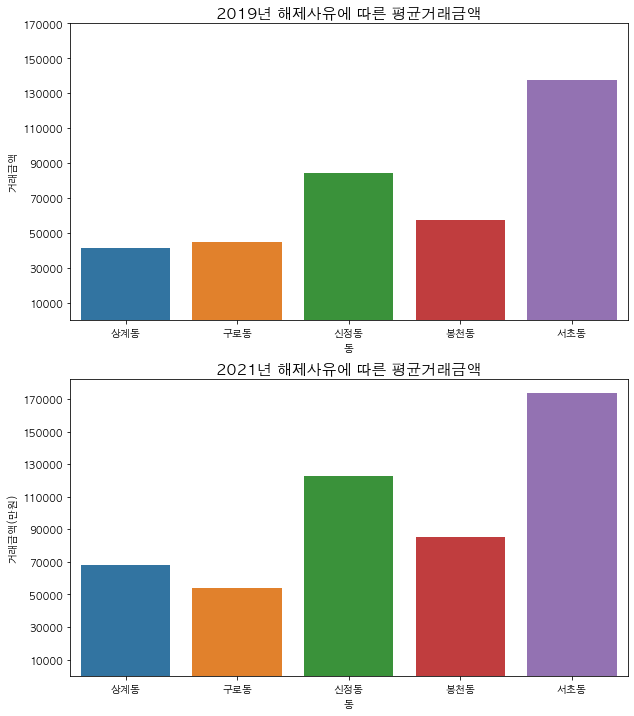

In [19]:
plt.figure(figsize=(10,12))
n = 2

h_2019_con = apart_2021.groupby('동')[['해제사유발생일']].agg('count').sort_values(by='해제사유발생일',ascending=False).head()
h_2021_con = apart_2021.groupby('동')[['해제사유발생일', '거래금액(만원)']].agg({'해제사유발생일':'count', '거래금액(만원)':'mean'}).sort_values(by='해제사유발생일',ascending=False).head()

h_2019_con = apart_2021.groupby('동')[['해제사유발생일']].agg('count').sort_values(by='해제사유발생일',ascending=False).head()
temp = h_2019_con.reset_index()['동']
k = apart_2019.groupby('법정동')[['거래금액']].mean().reset_index()
k2 = pd.merge(k, temp,left_on='법정동', right_on='동', how='right')

plt.subplot(n,1,1)
sns.barplot(x = k2['동'], y =k2['거래금액']).set_title('2019년 해제사유에 따른 평균거래금액', fontsize=15)
plt.yticks(np.arange(10000, 180000, 20000))
plt.subplot(n,1,2)
sns.barplot(x = h_2021_con.index, y = h_2021_con['거래금액(만원)']).set_title('2021년 해제사유에 따른 평균거래금액', fontsize=15)
plt.yticks(np.arange(10000, 180000, 20000))
plt.show()

## 3-1 상계 구로 신정 봉천 서초의 평균거래 금액의 변화 vs 다른곳들의 평균 거래 금액의 변화

In [20]:
# 동이 상계 구로 신정 봉천 서초면 True
def find_add(a):
    add = ['상계동', '구로동', '신정동', '봉천동', '서초동']
    if a in add:
        return True
    return False

# 21년 : 상계 구로 신정 봉천 서초 중 해제사유가 발생한 아파트 조건
condition_21 = apart_2021['동'].apply(find_add) & apart_2021['해제사유발생일'].notnull()
data_21 = apart_2021[condition_21][['동', '단지명', '거래금액(만원)']]


# 19년 : 상계 구로 신정 봉천 서초 중 21년 해제사유가 발생한 아파트
condition_19 = apart_2019['법정동'].apply(find_add) & (apart_2019['아파트이름'].isin(data_21['단지명']))
data_19 = apart_2019[condition_19][['법정동', '아파트이름','거래금액']]
change = data_21.groupby('동')['거래금액(만원)'].mean() - data_19.groupby('법정동')['거래금액'].mean()
# change = data_21.groupby('단지명')['거래금액(만원)'].mean() - data_19.groupby('아파트이름')['거래금액'].mean()
change.dropna(inplace=True)

change

동
구로동    -1930.944423
봉천동    24267.335047
상계동    27866.139779
서초동    27113.782051
신정동    23304.655559
dtype: float64

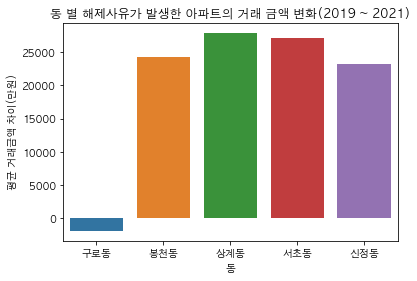

In [21]:
plt.yticks(np.arange(-20000, 30000, 5000))
plt.xlabel('동')
plt.ylabel('평균 거래금액 차이(만원)')
plt.title('동 별 해제사유가 발생한 아파트의 거래 금액 변화(2019 ~ 2021)')
sns.barplot(x=change.index, y=change.values)
plt.show()

## 3-2 상계 구로 신정 봉천 서초 중에서 해제사유가 발생하지 않은 아파트 들의 변화

In [22]:
# cond1 = apart_2021['null동'] == '가락동'
# apart_2021.loc[cond1]
condition_notCancel_2021 = apart_2021['null동'].apply(find_add) & apart_2021['해제사유발생일'].isnull()
data_notCancel_2021 = apart_2021[condition_notCancel_2021][['동', '단지명', '거래금액(만원)']]
data_notCancel_2021
# 19년 : 상계 구로 신정 봉천 서초 중 21년 해제사유가 발생한 아파트
condition_19 = apart_2019['법정동'].apply(find_add) & (apart_2019['아파트이름'].isin(data_notCancel_2021['단지명']))
data_notCancel_19 = apart_2019[condition_19][['법정동', '아파트이름','거래금액']]
change_notCancel = data_notCancel_2021.groupby('동')['거래금액(만원)'].mean() - data_notCancel_19.groupby('법정동')['거래금액'].mean()
change_notCancel

법정동
구로동   NaN
봉천동   NaN
상계동   NaN
서초동   NaN
신정동   NaN
dtype: float64